#  Data Integration and Reshaping
Date: 10.06.2019<br>
Environment: Python 3.6.8 and Anaconda 4.6.7 (64-bit)<br>

## 1. Introduction
>The main purpose of this report is to provide information about the methodology and process to solve this problem.<br>
This report focuses on two parts:
* Data Integration: integrate multiple datasets into one with required schema.
* Data reshaping: apply different normalization/transformation methods on data for building linear regression model.

## 2.  Logic map

> The procedures implemented in this data integration task are as follows:
<img src = "data/logicmap.png" height = "600" width = "900" style="float: left;">

## 3.  Import libraries 

In [1]:
import os
import ast
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import median
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from shapely.geometry import Point, shape
import shapefile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

## 4. Task 1: Data Integration

### 4.1 Data Pre-processing
> First, we load into the data and remove the duplicates.

In [2]:
raw_data = pd.read_csv('data/30086434.csv')

In [3]:
data = raw_data.copy()

In [4]:
data.head(2)

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID751720648,3 Gooch St,2,h,1010000.0,3/06/2017,1.0,0.0,245.0,49.0,-37.75789,145.00136
1,ID185086206,72 Hunter Rd,3,h,1620000.0,13/05/2017,2.0,2.0,575.0,19.0,-37.83780,145.09090


In [5]:
data.describe(include=['O'])

,ID,Address,Type,Date
count,720,720,720,720
unique,683,683,3,56
top,ID437935246,9 Stephens St,h,27/05/2017
freq,3,3,526,32


> remove the duplicates

In [6]:
data[data.duplicated(keep=False)].sort_values('ID').head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
390,ID131060708,4a Marriage Rd,4,h,1530000.0,14/05/2016,2.0,1.0,603.0,99.0,-37.91870,145.00710
310,ID131060708,4a Marriage Rd,4,h,1530000.0,14/05/2016,2.0,1.0,603.0,99.0,-37.91870,145.00710
453,ID132609725,6/767 High St,2,u,468000.0,15/07/2017,1.0,1.0,0.0,7.0,-37.72919,145.00533
316,ID132609725,6/767 High St,2,u,468000.0,15/07/2017,1.0,1.0,0.0,7.0,-37.72919,145.00533
483,ID146112361,9/723 Orrong Rd,2,u,655000.0,8/04/2017,1.0,1.0,1816.0,59.0,-37.83890,145.01410


In [7]:
data = data.drop_duplicates()

In [8]:
data[data.isnull().any(axis=1)]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude


### 4.2 Suburb Assignment
> We retrieve data from shape file and find the suburb boundary for each property.

In [9]:
data['Suburb'] = 'not available'

In [11]:
#open the shapefile
shp = shapefile.Reader('data/vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp') 
all_shapes = shp.shapes()# get all the polygons
all_records = shp.records()
len(all_records)

2973

In [12]:
# locate the index of desired suburb info
for i in range(len(all_records[0])):
    print(f'index:{i} ---> {all_records[0][i]}')

index:0 ---> 6670
index:1 ---> 2011-08-31
index:2 ---> None
index:3 ---> VIC2615
index:4 ---> 2012-04-27
index:5 ---> None
index:6 ---> UNDERBOOL
index:7 ---> 
index:8 ---> 
index:9 ---> G
index:10 ---> None
index:11 ---> 2


In [13]:
def Suburb(lat, lon):
    '''
    function to assign suburb to individual property
    '''
    for i in range(len(all_shapes)):
        boundary = all_shapes[i] # get a boundary polygon
        if Point(lon,lat).within(shape(boundary)): # make a point and check if it's in the polygon
            s = all_records[i][6] # get the sixth field of the corresponding record
            break
    return s

In [14]:
data['Suburb'] = data.apply(lambda row: Suburb(row['Lattitude'],row['Longtitude']),axis = 1)

In [15]:
# check whether every property has been assigned properly
data[data['Suburb']=='not available']

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb


### 4.3 Travel to CBD in the Weekday Morning

In [17]:
# unzip all the files under gtfs directory
from zipfile import ZipFile
for d in [1,2]: # 1 - Regional Train 2 - Metropolitan Train 
    current_dir = f'data/gtfs/{d}'
    zip_file_name = f'data/gtfs/{d}/google_transit.zip'
    with ZipFile(zip_file_name, 'r') as zipObj:
       # Extract all the contents of zip file in that directory
        zipObj.extractall(current_dir)

In [20]:
# collect files from different directory and generate dataframe
file_names= os.listdir('data/gtfs/1') # get all names for each gtfs directory
txt_files = [file for file in file_names if file.endswith('.txt')]
for file in txt_files:
    file_list = []
    for d in [1,2]: # turn each file into a dataframe
        file_name = f"data/gtfs/{d}/{file}"
        df = pd.read_csv(file_name)
        file_list.append(df)
    locals()[f'{file[:-4]}_raw'] = pd.concat(file_list, axis=0)
    exec(f'{file[:-4]}_raw.drop_duplicates(inplace=True)')
    exec(f'{file[:-4]}_raw.reset_index(drop=True, inplace=True)')
    print(f'Dataframe Generated ---> {file[:-4]}_raw')

Dataframe Generated ---> agency_raw
Dataframe Generated ---> calendar_dates_raw
Dataframe Generated ---> stop_times_raw
Dataframe Generated ---> shapes_raw
Dataframe Generated ---> trips_raw
Dataframe Generated ---> stops_raw
Dataframe Generated ---> calendar_raw
Dataframe Generated ---> routes_raw


> After investigate the database design schema and data integration requirements, we decide that only 5 files will be involved in this task.

In [21]:
stop_times = stop_times_raw.copy()
trips = trips_raw.copy()
stops = stops_raw.copy()
calendar = calendar_raw.copy()
routes = routes_raw.copy()

In [22]:
# only save the service id when all weekday have services
wkd_service_id = calendar.query('monday==1 & tuesday==1 & wednesday==1 & thursday==1 & friday==1')['service_id'].values

In [23]:
wkd_service_id

array(['T0', 'T0_1', 'T0_2', 'T0_3', 'T0'], dtype=object)

In [24]:
calendar.query('service_id in @wkd_service_id')

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
6,T0,1,1,1,1,1,0,0,20190515,20190523
13,T0_1,1,1,1,1,1,0,0,20190530,20190606
16,T0_2,1,1,1,1,1,0,0,20190607,20190628
20,T0_3,1,1,1,1,1,0,0,20190629,20190810
51,T0,1,1,1,1,1,0,0,20190524,20190810


In [25]:
# locate the trip with weekday services
wkd_trip = trips[trips.service_id.isin(wkd_service_id)]['trip_id'].values

In [26]:
SC = stops[stops.stop_name.str.find('Southern Cross Railway Station (Melbourne City)')!= -1]
SC

,stop_id,stop_name,stop_lat,stop_lon
7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525
319,22180,Southern Cross Railway Station (Melbourne City),-37.817936,144.951411


In [27]:
SC_id = stops[stops.stop_name.str.find('Southern Cross Railway Station (Melbourne City)')!= -1].stop_id.values

In [28]:
# fix the time format for future processing
def Hour_convert(time):
    if time.startswith('24'):
        return f'00{time[2:]}'
    else:
        return time
stop_times['arrival_time'] = stop_times['arrival_time'].apply(Hour_convert)
stop_times['departure_time'] = stop_times['departure_time'].apply(Hour_convert)

In [29]:
# locate the trips with SC and SC is not the first stop
SC_trip_id = stop_times.query('stop_id in @SC_id & trip_id in @wkd_trip & stop_sequence!= 1').trip_id.tolist()

In [30]:
def MorngDepart(time):
    '''
    function to check whether time between 7:00 and 9:30
    '''
    morning_7 = datetime.strptime('07:00:00','%H:%M:%S').time()
    morning_930 = datetime.strptime('09:30:00','%H:%M:%S').time()
    dep = datetime.strptime(time,'%H:%M:%S').time()
    if dep >= morning_7 and dep <= morning_930:
        return True
    else:
        return False

In [31]:
def TravelTime(dep_time,SCarrival_time):
    '''
    function to calculate travel time in minutes
    '''
    dep = datetime.strptime(dep_time,'%H:%M:%S')
    arr = datetime.strptime(SCarrival_time,'%H:%M:%S')
    delta = (arr-dep)
    return delta.seconds/60

In [32]:
# calculate the travel time to SC for each stops
stop_tt = dict()       # initial with a dict
for i in SC_trip_id:   # retrieve each trip includes SC as a df
    trip_df = stop_times.query('trip_id== @i')  
    
    # get the index of SC and only select the travel until arrive to SC
    SC_index = trip_df[trip_df.stop_id.isin(SC_id)].index.item()
    stops_to_SC = trip_df.query('index <= @SC_index')
    
    # Then, the last line would be SC stop info
    SCarrival = stops_to_SC.iloc[-1,:].arrival_time
    
    # check departure time and calculate travel time to SC for each stops in the trip
    for j in range(len(stops_to_SC)-1):
        line = stops_to_SC.iloc[j,:]
        if MorngDepart(line.departure_time):
            tt = TravelTime(line.departure_time,SCarrival)
            if line.stop_id not in stop_tt.keys():
                stop_tt[line.stop_id] = [tt]
            else:
                stop_tt[line.stop_id].append(tt)

In [33]:
# calculate the average travel time and record the number of trips
stop_tt_avg = dict()
for k,v in stop_tt.items():
    stop_tt_avg[k] = (sum(v)/len(v),len(v))

In [34]:
# locate the stops which involve SC station in weekdays
station_to_SC = list(stop_tt_avg.keys())
station_to_SC_df = stops.query('stop_id in @station_to_SC')
station_to_SC_df['tt'] = station_to_SC_df.apply(lambda row: stop_tt_avg[row['stop_id']][0], axis=1)
station_to_SC_df['number_of_trips'] = station_to_SC_df.apply(lambda row: stop_tt_avg[row['stop_id']][1], axis=1)

In [35]:
# combine SC itself into the dataframe
SC['tt'] = 0
SC['number_of_trips'] = 0
len(station_to_SC_df)

285

In [36]:
station_to_SC_df = pd.concat([station_to_SC_df,SC], axis=0)

In [37]:
station_to_SC_df.head(2)

,stop_id,stop_name,stop_lat,stop_lon,tt,number_of_trips
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,56.75,16
1,19980,Melton Railway Station (Melton South),-37.703293,144.572524,39.60,20


In [38]:
# define the function to calculate distance between two point on the earth
from math import radians, cos, sin, asin, sqrt
def haversine(lat1,lon1,lat2,lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6378
    dist_m = 6378* c*1000
    return dist_m

In [39]:
def NearestStation(prty_lat,prty_lon,df):
    data_to_each_stop = []
    
    # calculate the distance from property to each station
    for stop_id,s_lat,s_lon,tt,num_trips in df[['stop_id','stop_lat','stop_lon','tt','number_of_trips']].values:
        data_to_each_stop.append([haversine(s_lat,s_lon,prty_lat,prty_lon),stop_id,tt,num_trips])
    
    # retrieve all stations with minimum distance 
    min_dist,nearest_id = min(data_to_each_stop)[0:2]
    min_dist_station = [i for i in data_to_each_stop if i[0]==min_dist]
    # calculate the avg travel time
    if nearest_id in SC_id.tolist():
        travel_time = 0
    else:
        travel_time = sum([i[2]*i[3] for i in min_dist_station])/sum([i[3] for i in min_dist_station])
    return (int(nearest_id),min_dist,travel_time)

In [40]:
train_station_id = []
distance_to_train_station = []
travel_min_to_CBD = []
for lat, lon in data[['Lattitude','Longtitude']].values:
    s_id,dist,tt = NearestStation(lat,lon,station_to_SC_df)
    train_station_id.append(s_id)
    distance_to_train_station.append(dist)
    travel_min_to_CBD.append(tt)

In [41]:
data['train_station_id'] = train_station_id

In [42]:
data['distance_to_train_station'] = distance_to_train_station

In [43]:
data['travel_min_to_CBD'] = travel_min_to_CBD

In [44]:
data[data['travel_min_to_CBD']==0]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD
19,ID624764070,364 Montague St,2,h,1562500.0,15/10/2016,1.0,0.0,141.0,129.0,-37.84240,144.95620,ALBERT PARK,20043,2698.341593,0.0
97,ID405753924,247 York St,3,h,1250000.0,8/10/2016,2.0,0.0,224.0,129.0,-37.83290,144.95290,SOUTH MELBOURNE,20043,1621.747908,0.0
263,ID236780195,13 Martin St,3,h,1780000.0,20/05/2017,2.0,2.0,202.0,109.0,-37.83700,144.95850,SOUTH MELBOURNE,20043,2143.201022,0.0
376,ID474222024,405/1 Danks St W,1,u,470000.0,22/08/2016,1.0,1.0,0.0,19.0,-37.84360,144.94400,PORT MELBOURNE,20043,2910.662746,0.0
401,ID312699424,8 Ferrars Pl,4,h,4100000.0,27/05/2017,2.0,1.0,403.0,119.0,-37.83737,144.95799,SOUTH MELBOURNE,20043,2172.799919,0.0
445,ID761999640,309/166 Rouse St,2,u,655000.0,18/06/2016,1.0,1.0,0.0,13.0,-37.84160,144.93900,PORT MELBOURNE,20043,2849.819864,0.0
660,ID469035127,133/95 Rouse St,2,u,1070000.0,10/09/2016,2.0,1.0,0.0,16.0,-37.84350,144.94150,PORT MELBOURNE,20043,2964.332871,0.0
676,ID710936726,308/15 Pickles St,3,u,800000.0,24/06/2017,1.0,2.0,0.0,11.0,-37.84426,144.94415,PORT MELBOURNE,20043,2978.425858,0.0


### 4.4 Over_priced
> Here, we calculate the median price of similar properties and check whether it is overpriced

In [45]:
over_priced_list = []
for i in range(len(data)):
    bedr, p_type, bathr,parking,suburb,price,date = data.iloc[i,:][['Rooms','Type','Bathroom','Car','Suburb','Price','Date']].values
    year = date[-4:]
    similar_property = data.query('Rooms==@bedr & Type==@p_type & Bathroom==@bathr \
                        & Car==@parking & Suburb==@suburb & Date.str.endswith(@year)',engine='python')
    over_priced_list.extend([1 if price > median(similar_property.Price) else 0])

In [46]:
data['over_priced?'] = over_priced_list

In [47]:
sum(over_priced_list)

52

### 4.5 Average Crime Rate 
> Here, we use missing value dataset to exploration

In [48]:
excel_data = pd.ExcelFile('data/crimebylocationdatatable-yearending31march2016.xlsx')
crime = excel_data.parse('Table 1')
crime = crime.dropna(0, how = 'all')
crime = crime.dropna(1, how = 'all')
crime = crime.drop(crime.index[0])
#df.head()

In [49]:
crime.columns = crime.iloc[0].tolist()
crime = crime.drop(crime.index[0])
crime.index = range(len(crime.index))
crime.rename(columns={'Local Government Area':'LGA','CSA Offence Division':'CSA_Type',
                     'Apr - Mar reference period':'year'},inplace=True)
crime['LGA ERP'] = crime['LGA ERP'].apply(lambda x: int(x))
crime.head(2)

,year,Police Region,Police Service Area,LGA,CSA_Type,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521


In [50]:
with open("data/councils.txt", "r") as f:
    councils_txt = f.readlines()
gov_area = dict()
for i in councils_txt:
    l = i.split(':')
    gov_area[l[0].strip()] = ast.literal_eval(l[1].strip())

In [51]:
# display the format of gov_area dict
dict(list(gov_area.items())[0:2])

{'BANYULE': ['Abbotsford', 'Airport West', 'Albert Park', 'Alphington'],
 'BRIMBANK': ['Altona', 'Altona North', 'Armadale', 'Ascot Vale']}

In [52]:
def Crime(date, suburb, crime_type, gov_area_dict,crime_df):
    year = int(date[-4:])
    # retrieve the corresponding goverment area
    g_area = [k for k,v in gov_area_dict.items() if suburb.title() in v][0]
    # use aggregation to generate series of crime sum for each year
    crime_by_year = crime_df[(crime_df.LGA ==g_area) & (crime_df.CSA_Type.str.startswith(crime_type))]\
                    .groupby('year')['Offence Count'].agg('sum')
    # extract the available year before property sold
    available_year = [i for i in crime_by_year.index if i < year and i>=year-3]
    # calculate the crime for each available year
    crime_rate = [x for x in crime_by_year[available_year]]
    crime_rate_avg  = sum(crime_rate)/len(crime_rate)
    return crime_rate_avg

In [53]:
data['crime_A_average'] = data.apply(lambda row: Crime(row['Date'],row['Suburb'],'A',gov_area,crime),axis = 1)

In [54]:
data['crime_B_average'] = data.apply(lambda row: Crime(row['Date'],row['Suburb'],'B',gov_area,crime),axis = 1)

In [55]:
data['crime_C_average'] = data.apply(lambda row: Crime(row['Date'],row['Suburb'],'C',gov_area,crime),axis = 1)

In [56]:
data_output = data[['ID', 'Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car',\
                   'Landsize', 'Age', 'Lattitude', 'Longtitude','train_station_id', 'distance_to_train_station',\
                   'travel_min_to_CBD','over_priced?', 'crime_A_average', 'crime_B_average','crime_C_average']]

In [57]:
data_output.columns = ['ID', 'Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car',\
                   'LandSize', 'Age', 'Latitude', 'Longitude','train_station_id', 'distance_to_train_station',\
                   'travel_min_to_CBD','over_priced?', 'crime_A_average', 'crime_B_average','crime_C_average']

In [58]:
data_output.to_csv('solution.csv',index=False)

## 5. Task 2: Data Reshaping

### 5.1 Why should we reshape the data when it is already clean?

> Now, we've combine all the informatino we want into one dataframe and we know that the data is clean. However, if we want to build a linear model on top of it, only cleaning alone will not make ready for data. <br>
The reason is simple: **data is clean, but not good enough for machine to learn.**

### 5.1.1 Scaling for fair competition between features

In [102]:
datatask2 = pd.read_csv('solution.csv')
data1 = datatask2.copy()
data2 = data1[['Rooms','crime_C_average','travel_min_to_CBD','Age','Price']]
data2.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price
count,683.000000,683.000000,683.000000,683.000000,6.830000e+02
mean,3.039531,431.851635,27.014821,55.339678,1.102225e+06
std,0.971691,385.740216,11.164978,35.893113,6.517501e+05
min,1.000000,1.000000,0.000000,3.000000,2.450000e+05
25%,2.000000,159.333333,19.090909,23.000000,6.550000e+05
50%,3.000000,338.333333,26.500000,49.000000,9.370000e+05
75%,4.000000,586.666667,34.000000,79.000000,1.362000e+06
max,8.000000,2042.333333,68.818182,147.000000,5.510000e+06


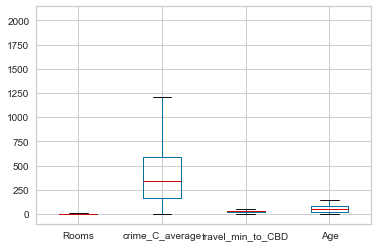

In [103]:
# plot boxplots of each predictor
data2.boxplot(column=['Rooms','crime_C_average','travel_min_to_CBD','Age'])

> From the boxplot above, we can see how different columns have different range of values.<br>  e.g.the range of crime feature lie from 0 to 1250 but the range of values of age feature is in 3 - 150. <br> That means a column is more weighted compared to other. The age range can never beat the crime range!! <br>
**Our model will be biased towards the one with higher range or higher variance**.

>In such a situation, applying statistical measures across this data set may not give desired result. Therefore, we need to put everything in a same scale. 

### 5.1.2 Transform to create the desired dimension

> The goal of reshaping data under **<font color=blue>Multiple Linear Regression Assumptions</font>** <br>
> Multiple linear regression analysis makes several key assumptions:<br>
>1. **Linearity**<br>
There must be a linear relationship between the outcome variable and the independent variables.
> 2. **Normality**<br>
Multivariate Normality–Multiple regression assumes that the residuals are normally distributed.
> 3. **Indpendence**<br>
Multiple regression assumes that the independent variables are not highly correlated with each other. 
> 4. **Equal-variance**<br>
This assumption states that the variance of error terms are similar across the values of the independent variables.

> Here, the first two assumptions are our main focus in this task: <br>
* Linear model expect the normal data. It works better on the normal shape of data.<br>
* For linear model, if the relationship between predictor and target is not linear, it also works. But it cannot learn that data well. <br>

**Therefore, our goal is to make the dimension where data is normal and easy to identify the linear relationships.**

### 5.1.3 Combination of Transformation and Normalization
> When the current dimension is not what we want, then transformation will help us to create a desired new dimension.
> After we get the desired dimension, we still need to consider about the scaling issue. Thus, normalization will be applied after transformation. <br>

> The reason why we need to transform first and then normalize it is that the range of domain after transformation is full of uncertain. Furthermore, if the shape is not what we want, then what would be the meaning of normalizing it? 

### 5.2 Reshape the Target Variable 

>First, let's take a look at how the target looks like.

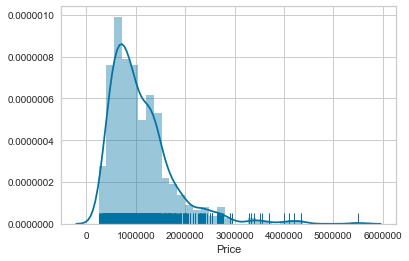

In [104]:
sns.distplot(data2['Price'], rug=True)

>There are so many outliers in our dataset thus it is **right skewed**.

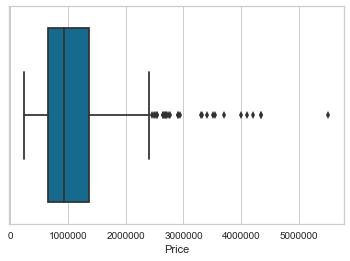

In [105]:
sns.boxplot(data2['Price'])

> If the data is skewed, we cannot do data normalization on it since **z-score normalization is sensitive to outliers**.<br>
The outliers move the mean and standard deviation toward themselves. They reduce the effect of themselves.<br>i.e.they don't look like outliers anymore.<br>

>Alternatively, we will use log or root transformation to reduce the positive skewness and make the target normal.

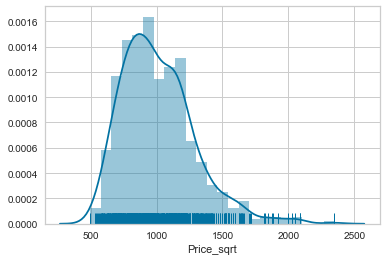

In [106]:
data2['Price_sqrt'] = data2['Price'].apply(math.sqrt)
sns.distplot(data2['Price_sqrt'], rug=True)

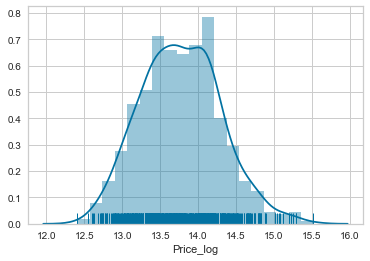

In [107]:
data2['Price_log'] = data2['Price'].apply(math.log)
sns.distplot(data2['Price_log'], rug=True)

### 5.3 Reshape the Predictors for linear relationship

### 5.3.1 Rooms as categorical feature? No.

> Let's start from Rooms feature and plot using the original rooms.

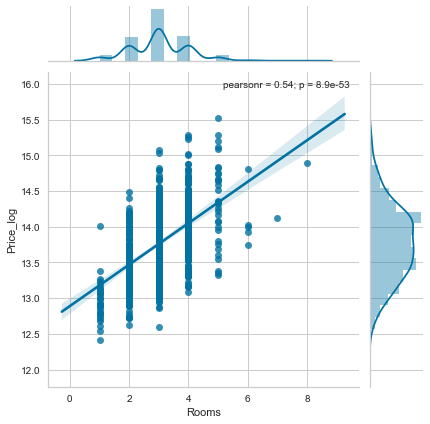

In [108]:
rooms = sns.jointplot(data=data2, x='Rooms', y='Price_log', kind='reg')
rooms.annotate(stats.pearsonr)

## ori PRICE

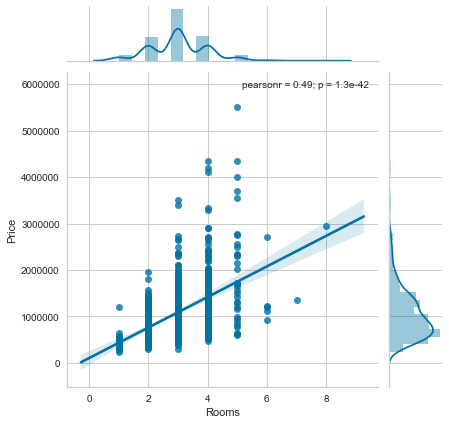

In [109]:
rooms = sns.jointplot(data=data2, x='Rooms', y='Price', kind='reg')
rooms.annotate(stats.pearsonr)

In [110]:
rooms_scaled = data2['Rooms'].values
data2['Rooms_znorm'] = preprocessing.scale(rooms_scaled)

> Here, we can see that the 'Rooms' feature is a discrete variable rather than continuous. Normally, we will change it to categorical feature since we don't want our model to learn from the meaningless numerical difference between categories. <br>

> However, in this case, **<font color=blue>the number of rooms does have significant meaning.</font>**<br>  We have to keep them as numbers otherwise we will lose all the information about rooms.

> The correlation coefficient which indicates the linear relationship between price and rooms shows that the linear relationship is positive and the coefficient is 0.54.

> The only thing we need to consider is the scale. Since the data is not highly skewed, we can try normalization on it first and decide whether to do it in the final model when all features are involved.

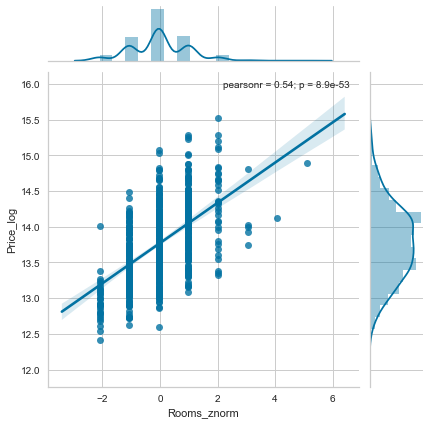

In [111]:
# directly normalize the data
rooms_znorm = sns.jointplot(data=data2, x='Rooms_znorm', y='Price_log', kind='reg')
rooms_znorm.annotate(stats.pearsonr)

### 5.3.2 Crime feature

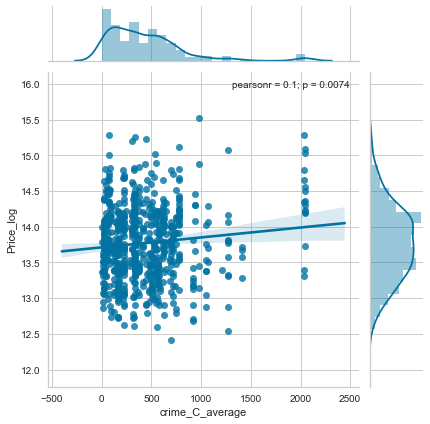

In [112]:
# Original crime data shape
crime = sns.jointplot(data=data2, x='crime_C_average', y='Price_log', kind='reg')
crime.annotate(stats.pearsonr)

> From the jointplot above, two things are clear:<br>
1. The correlation (linear relationship) between crime and price is pretty low. The regression line is approximately near to the mean of price which means **<font color=blue>it wouldn't be much better to use crime for prediction than just use price's own mean (Null Model).</font>**<br> But we will try to do some transformation to see potential improvement.

> 2. The crime data is highly right-skewed. Those data over 2000 drag the tail so far away from the center of crime distribution. <br>Therefore, we want to **<font color=blue>compress the larger data point to the left.</font>**<br> 
> Two options for shrinking the shape: Log or Root:

In [113]:
data2['crime_C_average_sqrt'] = data2['crime_C_average'].apply(math.sqrt)
data2['crime_C_average_log'] = data2['crime_C_average'].apply(math.log)

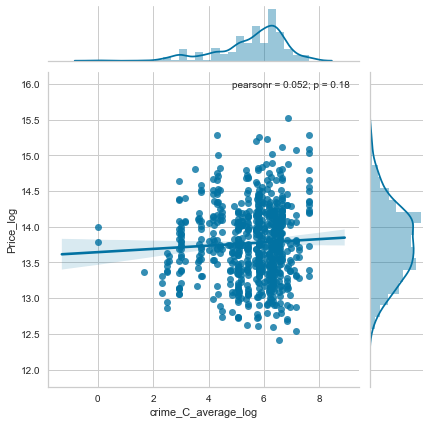

In [114]:
# use log transformation to shrink the data
crime_log = sns.jointplot(data=data2, x='crime_C_average_log', y='Price_log', kind='reg')
crime_log.annotate(stats.pearsonr)

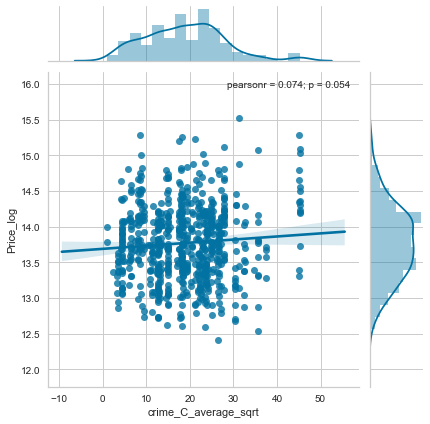

In [115]:
# use root transformation to shrink the data
crime_root = sns.jointplot(data=data2, x='crime_C_average_sqrt', y='Price_log', kind='reg')
crime_root.annotate(stats.pearsonr)

> After Transformation, the pearson r (indicating linear relationship) is even smaller. <br>
So we decide**<font color=blue> not to include this crime feature in our final model.</font>**<br>


### 5.3.3 Travel time to CBD

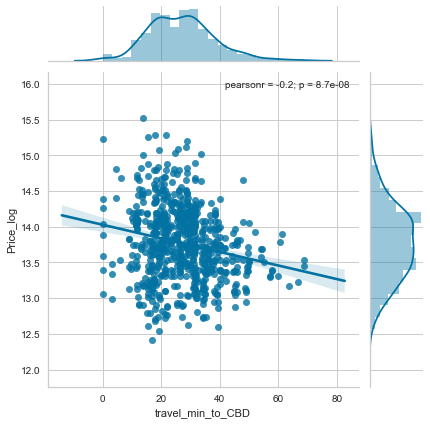

In [116]:
# Original travel time data shape
tt = sns.jointplot(data=data2, x='travel_min_to_CBD', y='Price_log', kind='reg')
tt.annotate(stats.pearsonr)

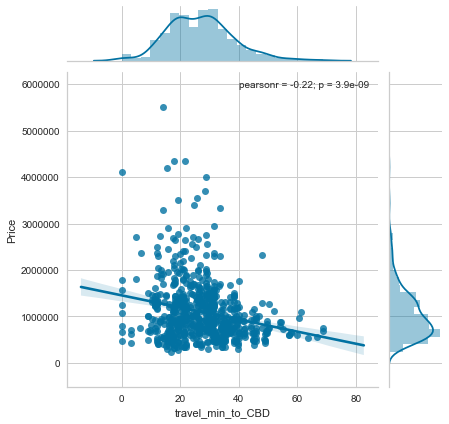

In [117]:
# Original travel time data shape
tt = sns.jointplot(data=data2, x='travel_min_to_CBD', y='Price', kind='reg')
tt.annotate(stats.pearsonr)

> From the plot above, the linear relationship is pretty clear and the pearson r is -0.2.<br>
> The problem of this feature is its scale. The range is between 0 to about 70. <br>
> Since the data is not skewed, we can **<font color=blue>either transform it to a smaller range or use normalization directly.</font>**<br> 

In [118]:
# change 0 to 0.01 in order to try the log transformation
data2.loc[data2.travel_min_to_CBD==0,'travel_min_to_CBD'] = 0.001
data2['travel_min_to_CBD_sqrt'] = data2['travel_min_to_CBD'].apply(math.sqrt)
data2['travel_min_to_CBD_log'] = data2['travel_min_to_CBD'].apply(math.log)
tt_scaled = data2['travel_min_to_CBD'].values
data2['travel_min_to_CBD_znorm'] = preprocessing.scale(tt_scaled)

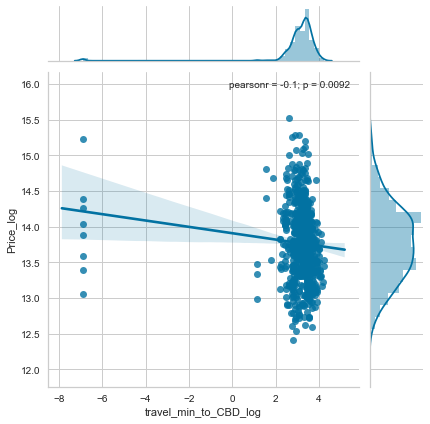

In [119]:
# use log transformation to shrink the data
tt_log = sns.jointplot(data=data2, x='travel_min_to_CBD_log', y='Price_log', kind='reg')
tt_log.annotate(stats.pearsonr)

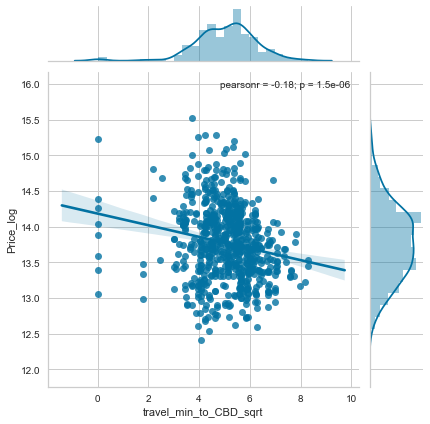

In [120]:
# use root transformation to shrink the data
tt_root = sns.jointplot(data=data2, x='travel_min_to_CBD_sqrt', y='Price_log', kind='reg')
tt_root.annotate(stats.pearsonr)

## ori PRICE & travel_min_sqrt

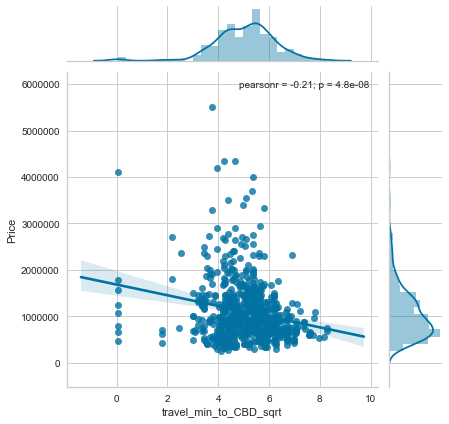

In [121]:
# use root transformation to shrink the data
tt_root = sns.jointplot(data=data2, x='travel_min_to_CBD_sqrt', y='Price', kind='reg')
tt_root.annotate(stats.pearsonr)

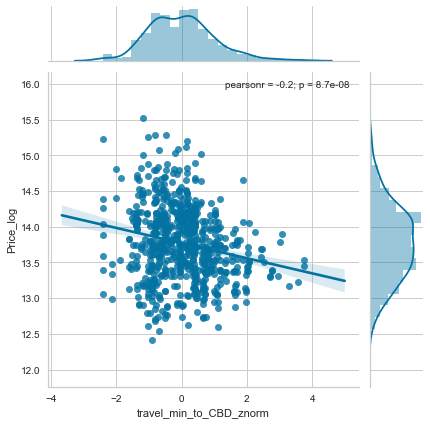

In [122]:
# normalize the data directly
tt_norm = sns.jointplot(data=data2, x='travel_min_to_CBD_znorm', y='Price_log', kind='reg')
tt_norm.annotate(stats.pearsonr)

> We will keep the last two options here for further discussion when all features involved.

### 5.3.4 Property Age

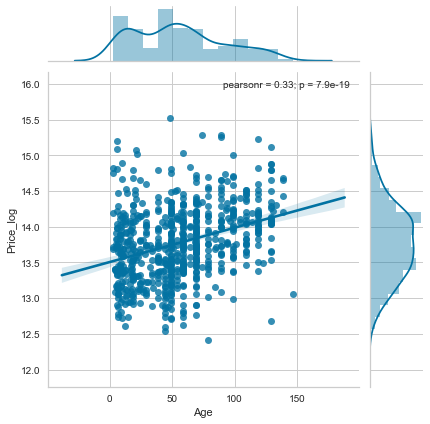

In [123]:
# Original age data shape
age = sns.jointplot(data=data2, x='Age', y='Price_log', kind='reg')
age.annotate(stats.pearsonr)

> From the plot above, the linear relationship is pretty clear and the pearson r is o.33.<br>
> The problem of this feature is its scale. The range is between 0 to about 150.<br>
> Then we need to **<font color=blue>either transform it to a smaller range or use normalization (with some risk since it's slightly right skewd).</font>**<br> 

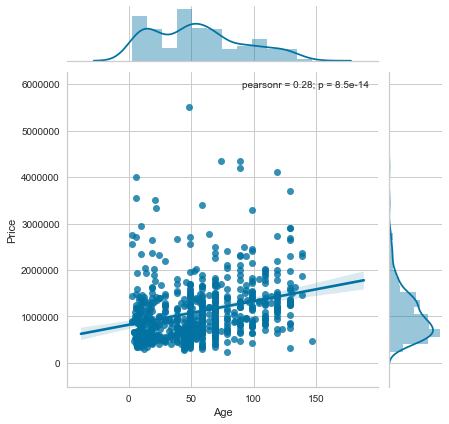

In [124]:
# Original age data shape
age = sns.jointplot(data=data2, x='Age', y='Price', kind='reg')
age.annotate(stats.pearsonr)

In [125]:
data2['Age_sqrt'] = data2['Age'].apply(math.sqrt)
data2['Age_log'] = data2['Age'].apply(math.log)
age_scaled = data2['Age'].values
data2['Age_znorm'] = preprocessing.scale(age_scaled)

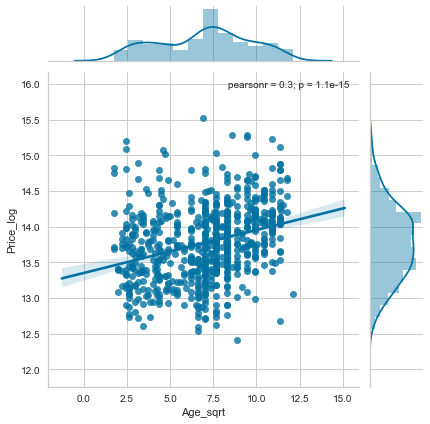

In [126]:
age_sqrt = sns.jointplot(data=data2, x='Age_sqrt', y='Price_log', kind='reg')
age_sqrt.annotate(stats.pearsonr)

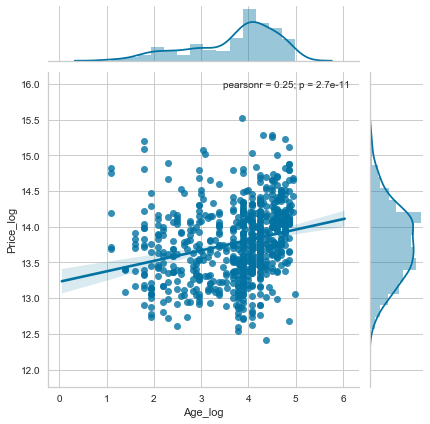

In [127]:
age_log = sns.jointplot(data=data2, x='Age_log', y='Price_log', kind='reg')
age_log.annotate(stats.pearsonr)

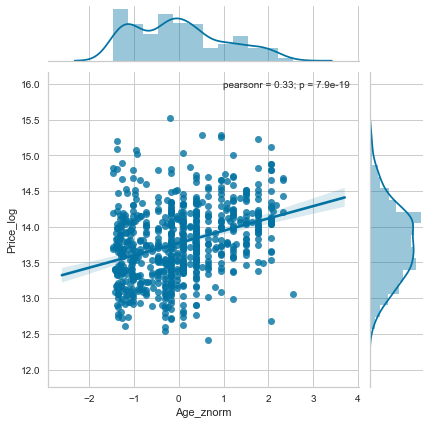

In [128]:
age_znorm = sns.jointplot(data=data2, x='Age_znorm', y='Price_log', kind='reg')
age_znorm.annotate(stats.pearsonr)

> These three reshaping method doesn't not significantly change the shape of the data.<br>
> Thus, we'll consider other features together. 

### 5.4 Comparison of different reshaping methods

> Now, we need to involve all three significant features together to decide the final reshaping method to use.<br>
> Since the normality and linear relationship are already considered, we only consider the scaling issue for this stage. 

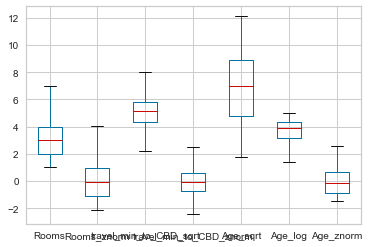

In [129]:
# plot boxplots of each predictor
data2.boxplot(column=['Rooms','Rooms_znorm','travel_min_to_CBD_sqrt','travel_min_to_CBD_znorm',\
                      'Age_sqrt','Age_log','Age_znorm'])

> **In terms of the scale**, we can either choose the combination of 'Rooms','travel_min_to_CBD_sqrt','Age_log', or 'Rooms_znorm','travel_min_to_CBD_znorm','Age_znorm'. But it worths noting that, by using normalization, if the data is skwed, then the normalization would be more risky.

> Now, we want to build the original model (using unshaped data) and compare it with our final two choices. 

In [130]:
# define a function to build linear regression model
def lineaRegression(df,target,predictor_list):
    X = df.loc[:,(predictor_list)]
    Y = df.loc[:,target]
    lm = LinearRegression()
    lm.fit(X,Y)
    print ('r-squared for this model = ',round(lm.score(X,Y),4))
    feature_cols = predictor_list
    B=list(zip(feature_cols,lm.coef_))
    df_coe = pd.DataFrame(B, columns = ['Variable','coef']) 
    print(f'{df_coe}\n')  
    print (f'intercept:{lm.intercept_}')

    visualizer = ResidualsPlot(lm)
    visualizer.fit(X,Y)
    visualizer.score(X,Y)
    visualizer.poof() 

### Model with full unshaped features

r-squared for this model =  0.407
            Variable           coef
0              Rooms  372766.840760
1    crime_C_average     228.676300
2  travel_min_to_CBD  -17730.028272
3                Age    3058.497058

intercept:180151.9721985982


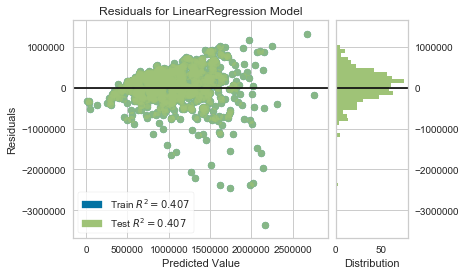

In [131]:
lineaRegression(data2,'Price',['Rooms', 'crime_C_average', 'travel_min_to_CBD','Age'])

> Due to the scale issue, the estimators are wired. the residual is right skewed.

### Model using significant reshaped features (transformed but not normalized)

r-squared for this model =  0.4268
                 Variable      coef
0                   Rooms  0.322195
1  travel_min_to_CBD_sqrt -0.135170
2                 Age_log  0.112613

intercept:13.05902373980845


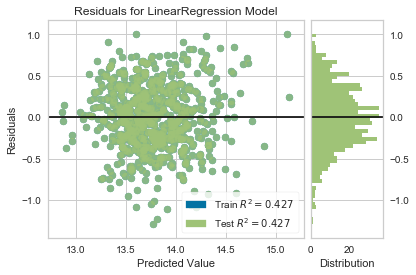

In [132]:
lineaRegression(data2,'Price_log',['Rooms','travel_min_to_CBD_sqrt','Age_log'])

### Model using significant reshaped features (normalized but not transformed)

r-squared for this model =  0.4531
                  Variable      coef
0              Rooms_znorm  0.309030
1  travel_min_to_CBD_znorm -0.149524
2                Age_znorm  0.120588

intercept:13.77131170413184


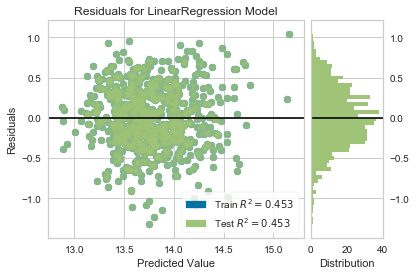

In [133]:
# Model using reshaped features (transformed but not normalized)
lineaRegression(data2,'Price_log',['Rooms_znorm','travel_min_to_CBD_znorm','Age_znorm'])

> Thus, from the above improved model we can see that, our reshaping techniques indeed improve the model performance slightly. The one applied with normalization on predictors works better than the one using transformation method. 

r-squared for this model =  0.3888
                  Variable           coef
0              Rooms_znorm  358669.588073
1  travel_min_to_CBD_znorm -200951.223837
2                Age_znorm  116036.652770

intercept:1102225.2386530014


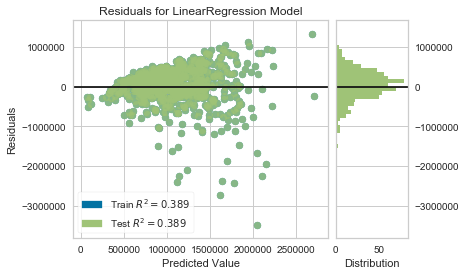

In [134]:
# Model using reshaped features (transformed but not normalized)
lineaRegression(data2,'Price',['Rooms_znorm','travel_min_to_CBD_znorm','Age_znorm'])

## 8. Conclusion
> What we have done in this task:
1. We create a **logic map** to handle the data integration problems, break them into component parts.
2. First, we use shape file to assign suburb.
3. Then, we use multiple filter steps to get the desired stops info and crime data we need for each property.
4. After we get all data, we prepare our data for linear regression model by applying different reshaping methods.
6. Finally, we compare two option models and conclude that the reshaping technique improve our model performance.